# Training by using the covariance matrix of multihead coherent state generation by pullback

Use the multihead (2-head) gates in the phase space 
to create a network that represent a coherent state,
by starting from a Gaussian state and making a pullback

Use the derivative and the covariance matrix for the training

NOTE: remember to shut down the kernel when out of memory

<img src="../img/complexcoherentCOV.png" width="900" height="300" />

<img src="../img/logo_circular.png" width="20" height="20" />@by claudio<br>

nonlinearxwaves@gmail.com<br>
@created 21 sep 2020<br>
@version 15 may 2023

In [1]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-05-14 11:14:28.652638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-14 11:14:28.652660: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float32

Precision for output on the screen

In [3]:
np.set_printoptions(precision=2)

## Dimension

In [4]:
N = 10

## Build vacuum by the Gaussian state

In [5]:
vacuum = ps.VacuumLayer(N)

2023-05-14 11:14:31.629718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-14 11:14:31.629752: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-14 11:14:31.629788: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2023-05-14 11:14:31.630160: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build the pullback layer for generating the input coherent state

The target displacement is a normalized vector

In [6]:
dinput = 3.0*np.ones((N,1)); 
norm = np.linalg.norm(dinput)
dinput = dinput /norm
print(dinput.transpose())

[[0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32]]


Check the normalization of the dtarget

In [7]:
print(np.dot(dinput.transpose(), dinput)) 

[[1.]]


### Build the Displacement layer
The layer is a constant layer, as no training is needed

In [8]:
D = ps.DisplacementLayerConstant(dinput)

## Define the layer for the constant random medium
The LinearConstantMultiHead generate by default a random medium with 
the relevant symplectic operator

In [9]:
R = ps.RandomLayerConstant(N)

## Define the trainable unitary layer

In [10]:
T = ps.RandomLayer(N)

## Define the normalized target displacement vector

In [11]:
dtarget = np.zeros((N,1)); dtarget[0]=1.0; dtarget[1]=0.5;
norm = np.linalg.norm(dtarget)
dtarget = dtarget /norm
print(dtarget.transpose())

[[0.89 0.45 0.   0.   0.   0.   0.   0.   0.   0.  ]]


Check the normalization

In [12]:
print(np.dot(dtarget.transpose(), dtarget)) 

[[1.]]


## Define the target covariance matrix

In [13]:
gtarget = np.eye(N);

## Connect the layers

Input layer

In [14]:
xin = tf.keras.layers.Input(N);print(xin)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [15]:
x3, a3 = R(xin)
x2, a2 = T(x3,a3)
x1, a1 = D(x2,a2)
chir, chii = vacuum(x1, a1) 
pullback = tf.keras.Model(inputs = xin, outputs=[chir, chii])

Add the covariance and derivative layer for evaluating the mean <R>

In [16]:
cov_layer = ps.CovarianceLayer(N)
g, Re, _ = cov_layer(chir,chii, pullback)

In [17]:
pullback_cov = tf.keras.Model(inputs = xin, outputs=[g, Re])

### Store the M,d of the LL_complex layer for later chek

In [18]:
M_R_tf, _=R.get_M(); M_R_np=M_R_tf.numpy()

In [19]:
d_R_np=R.d.numpy()

### Store the M, d of the untrained U_train layer for later check

In [20]:
WR_untrained_T = T.WR.numpy()

In [21]:
WI_untrained_T = T.WI.numpy()

In [22]:
M_untrained_T, MI_untrained_T = T.get_M()

## Auxiliary staff

Tensor flow function that returns the gradient

In [23]:
@tf.function
def derivative():
    x = tf.constant(np.zeros((1,N)))
    with tf.GradientTape() as tape:
        tape.watch(x)
        cr, ci = pullback(x)
        chii_x = tape.gradient(ci, x)
    return chii_x

Tensor flow function that returns the covariance matrix

In [24]:
@tf.function
def covariance_matrix():
    x = tf.constant(np.zeros((1,N)))
    with tf.GradientTape(persistent=True) as t1:
        t1.watch(x)
        with tf.GradientTape(persistent=True) as t2:
            t2.watch(x)
            cr, ci = pullback(x)
        cr_x = t2.gradient(cr, x)
        ci_x = t2.gradient(ci, x)
    d2cr= t1.jacobian(cr_x,x)
    # reshape the Jacobian to a matrix
    Hc2 = tf.reshape(d2cr, [N,N])
    # evaluate the covariance with the factor 2.0 to account for the definition of g
    cov = -2*(Hc2+tf.matmul(ci_x,ci_x,transpose_a=True))      
    return cov

## Build the training set by using a target characteristic function

Number of training points
Also a single training point is enough for Gaussian state, more points improve the training

In [25]:
Nbatch = 100

Define the numpy function for the target characteristic function:
    a coherent state with a target displacement
One need a target d for any training points

In [26]:
xtrain = np.random.rand(Nbatch, N)-0.5
Rtrain = np.zeros((Nbatch,N))
gtrain = np.zeros((Nbatch,N,N))
for j in range(Nbatch):
    for i in range(N):
        Rtrain[j,i]=dtarget[i]
        for k in range(N):
            gtrain[j,i,k]=gtarget[i,k]

## Train the model

In [27]:
pullback_cov.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error')

Summary of the derivative model

In [28]:
pullback_cov.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 random_layer (RandomLayer)     [(None, 10),         50          ['input_1[0][0]']                
                                 (10, 1)]                                                         
                                                                                                  
 random_layer_1 (RandomLayer)   [(None, 10),         50          ['random_layer[0][0]',           
                                 (10, 1)]                         'random_layer[0][1]']           
                                                                                            

Test the call of the derivative layer

In [29]:
pullback_cov(xtrain)

[<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
 array([[ 1.00e+00, -5.22e-08, -8.94e-08, -3.73e-08,  5.96e-08, -1.49e-08,
         -5.96e-08,  8.94e-08,  1.79e-07, -5.96e-08],
        [-2.24e-08,  1.00e+00,  3.73e-08, -3.26e-08,  6.71e-08,  6.89e-08,
         -7.45e-08, -2.98e-08,  5.96e-08,  1.04e-07],
        [-5.96e-08,  8.94e-08,  1.00e+00, -3.35e-08,  8.94e-08,  1.42e-07,
          1.49e-08, -1.49e-08,  5.96e-08, -1.64e-07],
        [-7.45e-09, -4.47e-08,  3.17e-08,  1.00e+00, -6.71e-08,  3.91e-08,
         -1.86e-08,  5.40e-08,  1.15e-07,  1.30e-08],
        [ 2.98e-08,  2.24e-08, -2.98e-08, -8.20e-08,  1.00e+00,  7.45e-09,
         -1.49e-07, -1.19e-07, -1.19e-07, -0.00e+00],
        [-7.45e-09,  1.02e-07,  1.64e-07,  4.10e-08,  3.73e-08,  1.00e+00,
          2.01e-07, -1.34e-07,  1.49e-08,  6.71e-08],
        [-5.96e-08, -7.45e-08,  2.98e-08, -8.20e-08, -1.19e-07,  1.86e-07,
          1.00e+00, -2.98e-08, -0.00e+00, -1.34e-07],
        [-0.00e+00,  2.24e-08,  2.98e-08, -3.1

## Training of the model

In [30]:
history = pullback_cov.fit(x=xtrain,y=[gtrain, Rtrain], epochs=50, verbose=2)

Epoch 1/50
4/4 - 2s - loss: 0.0975 - covariance_layer_loss: 1.7383e-14 - covariance_layer_1_loss: 0.0975 - 2s/epoch - 533ms/step
Epoch 2/50
4/4 - 0s - loss: 0.0825 - covariance_layer_loss: 2.1623e-14 - covariance_layer_1_loss: 0.0825 - 9ms/epoch - 2ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0729 - covariance_layer_loss: 1.9084e-14 - covariance_layer_1_loss: 0.0729 - 7ms/epoch - 2ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0630 - covariance_layer_loss: 2.0528e-14 - covariance_layer_1_loss: 0.0630 - 9ms/epoch - 2ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0523 - covariance_layer_loss: 1.8512e-14 - covariance_layer_1_loss: 0.0523 - 8ms/epoch - 2ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0414 - covariance_layer_loss: 2.1024e-14 - covariance_layer_1_loss: 0.0414 - 9ms/epoch - 2ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0308 - covariance_layer_loss: 2.1583e-14 - covariance_layer_1_loss: 0.0308 - 8ms/epoch - 2ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0215 - covariance_layer_loss: 1.8391e-14 - covariance_layer_1_loss: 0.021

Text(0.5, 0, 'Epoch')

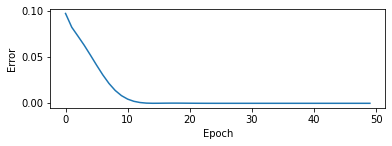

In [31]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epoch')

## Test the derivative of the model
Evaluate the expectation value of the displacement as derivative of the characterisc function

Use the derivative function for the derivative

In [32]:
utilities.printonscreen(derivative())

+0.9+0.0i +0.4+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i 


Use the covariance_matrix function for the covariance

In [33]:
utilities.printonscreen(covariance_matrix())

+1.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i 
+0.0+0.0i +1.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i 
-0.0+0.0i +0.0+0.0i +1.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i 
-0.0+0.0i -0.0+0.0i +0.0+0.0i +1.0+0.0i -0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i 
+0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i +1.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i 
-0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +1.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i -0.0+0.0i 
-0.0+0.0i -0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i +1.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i 
+0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i -0.0+0.0i +1.0+0.0i +0.0+0.0i +0.0+0.0i 
+0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +1.0+0.0i -0.0+0.0i 
-0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +

Use the model 

In [34]:
pullback_cov(xtrain)

[<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
 array([[ 1.00e+00, -0.00e+00, -1.79e-07,  5.12e-08,  6.12e-08, -2.14e-07,
          8.83e-08,  9.13e-08,  3.49e-08, -1.75e-07],
        [ 5.96e-08,  1.00e+00,  7.15e-08, -2.86e-07,  1.86e-07,  4.17e-08,
          1.84e-09, -8.72e-08,  2.33e-07,  1.59e-07],
        [-1.63e-07,  1.17e-07,  1.00e+00, -9.51e-09,  2.15e-07,  1.99e-07,
          1.95e-07,  1.07e-07,  9.57e-08, -6.99e-08],
        [-4.53e-08, -2.68e-07,  1.78e-08,  1.00e+00, -2.27e-07,  1.86e-07,
         -1.44e-07,  1.74e-07,  6.37e-08,  7.48e-08],
        [ 1.48e-07,  7.86e-08,  2.28e-07, -1.85e-07,  1.00e+00,  1.73e-08,
         -3.42e-07, -1.41e-07, -9.72e-08,  6.12e-08],
        [-1.65e-07,  1.93e-08,  2.32e-07,  1.70e-07,  8.53e-09,  1.00e+00,
          1.69e-07, -2.70e-07, -6.30e-08, -1.39e-07],
        [-1.13e-07, -3.15e-08,  2.28e-07, -1.42e-07, -3.18e-07,  1.41e-07,
          1.00e+00,  3.69e-09,  9.99e-08, -1.40e-07],
        [ 5.92e-08, -2.61e-08,  1.96e-07,  2.4

## Plot the model

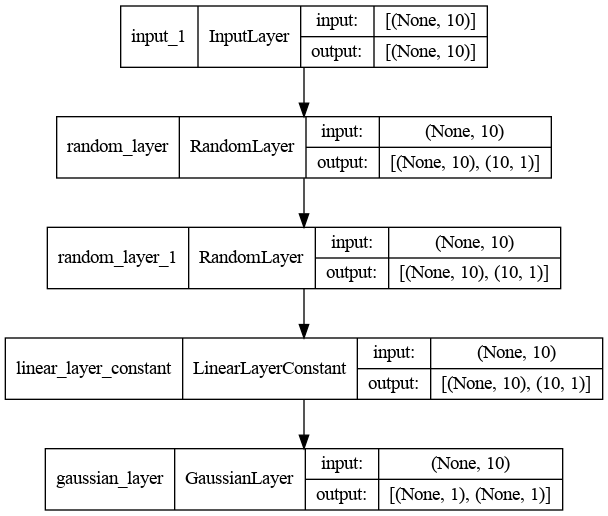

In [35]:
dot_img_file = 'pullback_COV.png'
tf.keras.utils.plot_model(pullback, to_file=dot_img_file, show_shapes=True)

## Check the weights of the layers

### d and M of the complex layer LL_complex (these are unchanged)

In [36]:
print(R.d.numpy().transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [37]:
print(d_R_np.transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [38]:
M_R, _ =R.get_M();print(M_R.numpy())

[[ 0.61  0.21  0.24 -0.22 -0.44 -0.19  0.17  0.28  0.37  0.04]
 [-0.21  0.61  0.22  0.24  0.19 -0.44 -0.28  0.17 -0.04  0.37]
 [ 0.01  0.13  0.54  0.12  0.21  0.1   0.45  0.27 -0.43 -0.41]
 [-0.13  0.01 -0.12  0.54 -0.1   0.21 -0.27  0.45  0.41 -0.43]
 [-0.06 -0.51  0.43 -0.15  0.46  0.04 -0.06  0.27  0.38  0.31]
 [ 0.51 -0.06  0.15  0.43 -0.04  0.46 -0.27 -0.06 -0.31  0.38]
 [ 0.21 -0.01 -0.42  0.42  0.33 -0.16  0.62  0.02  0.17  0.22]
 [ 0.01  0.21 -0.42 -0.42  0.16  0.33 -0.02  0.62 -0.22  0.17]
 [ 0.04  0.51  0.11 -0.15  0.32  0.51  0.06 -0.39  0.42 -0.08]
 [-0.51  0.04  0.15  0.11 -0.51  0.32  0.39  0.06  0.08  0.42]]


In [39]:
print(M_R_np)

[[ 0.61  0.21  0.24 -0.22 -0.44 -0.19  0.17  0.28  0.37  0.04]
 [-0.21  0.61  0.22  0.24  0.19 -0.44 -0.28  0.17 -0.04  0.37]
 [ 0.01  0.13  0.54  0.12  0.21  0.1   0.45  0.27 -0.43 -0.41]
 [-0.13  0.01 -0.12  0.54 -0.1   0.21 -0.27  0.45  0.41 -0.43]
 [-0.06 -0.51  0.43 -0.15  0.46  0.04 -0.06  0.27  0.38  0.31]
 [ 0.51 -0.06  0.15  0.43 -0.04  0.46 -0.27 -0.06 -0.31  0.38]
 [ 0.21 -0.01 -0.42  0.42  0.33 -0.16  0.62  0.02  0.17  0.22]
 [ 0.01  0.21 -0.42 -0.42  0.16  0.33 -0.02  0.62 -0.22  0.17]
 [ 0.04  0.51  0.11 -0.15  0.32  0.51  0.06 -0.39  0.42 -0.08]
 [-0.51  0.04  0.15  0.11 -0.51  0.32  0.39  0.06  0.08  0.42]]


### d and M of the trained layer, before and after training (they must change)

In [40]:
T.WR

<tf.Variable 'random_layer_1/WR:0' shape=(5, 5) dtype=float32, numpy=
array([[ 0.8 ,  0.13,  0.33,  0.39,  0.59],
       [ 0.76, -0.39,  0.08,  0.2 ,  0.55],
       [-0.41, -0.25,  1.14, -0.23,  0.2 ],
       [ 0.06,  0.63,  0.48,  0.15,  0.03],
       [ 0.99,  0.15,  0.45,  0.27,  1.19]], dtype=float32)>

In [41]:
WR_untrained_T

array([[0.29, 0.17, 0.81, 0.77, 0.39],
       [0.8 , 0.11, 0.43, 0.44, 0.51],
       [0.07, 0.11, 0.91, 0.19, 0.57],
       [0.44, 0.87, 0.89, 0.53, 0.32],
       [0.8 , 0.11, 0.81, 0.57, 0.98]], dtype=float32)

In [42]:
T.WI

<tf.Variable 'random_layer_1/WI:0' shape=(5, 5) dtype=float32, numpy=
array([[ 0.92,  0.63,  0.69, -0.02,  0.92],
       [ 0.88,  0.33,  0.95,  0.31,  0.66],
       [-0.07, -0.3 ,  0.23,  0.55, -0.28],
       [ 0.85,  0.38,  0.5 ,  0.81,  0.86],
       [-0.36,  0.25,  0.84,  0.26,  0.18]], dtype=float32)>

In [43]:
WI_untrained_T

array([[0.92, 0.71, 0.4 , 0.27, 0.55],
       [0.8 , 0.33, 0.64, 0.4 , 0.51],
       [0.23, 0.01, 0.23, 0.55, 0.04],
       [0.55, 0.28, 0.5 , 0.81, 0.49],
       [0.01, 0.4 , 0.52, 0.63, 0.18]], dtype=float32)

In [44]:
M_T, _= T.get_M(); print(M_T)

tf.Tensor(
[[ 0.64  0.22  0.28 -0.02  0.48 -0.31  0.21 -0.14 -0.16  0.24]
 [-0.22  0.64  0.02  0.28  0.31  0.48  0.14  0.21 -0.24 -0.16]
 [ 0.06  0.07  0.12  0.76 -0.38 -0.06  0.28 -0.28  0.26  0.14]
 [-0.07  0.06 -0.76  0.12  0.06 -0.38  0.28  0.28 -0.14  0.26]
 [-0.39  0.3   0.1   0.13  0.04 -0.39 -0.62 -0.25 -0.22  0.31]
 [-0.3  -0.39 -0.13  0.1   0.39  0.04  0.25 -0.62 -0.31 -0.22]
 [-0.48  0.24  0.32 -0.37 -0.05 -0.35  0.54 -0.01  0.23 -0.  ]
 [-0.24 -0.48  0.37  0.32  0.35 -0.05  0.01  0.54  0.    0.23]
 [-0.06  0.07 -0.23 -0.01  0.48  0.14 -0.15 -0.16  0.78  0.15]
 [-0.07 -0.06  0.01 -0.23 -0.14  0.48  0.16 -0.15 -0.15  0.78]], shape=(10, 10), dtype=float32)


In [45]:
print(M_untrained_T)

tf.Tensor(
[[ 0.66  0.4  -0.05 -0.22  0.29  0.3   0.2  -0.13 -0.3   0.17]
 [-0.4   0.66  0.22 -0.05 -0.3   0.29  0.13  0.2  -0.17 -0.3 ]
 [ 0.01 -0.01  0.63  0.38 -0.15  0.24  0.07 -0.43  0.19  0.39]
 [ 0.01  0.01 -0.38  0.63 -0.24 -0.15  0.43  0.07 -0.39  0.19]
 [-0.16  0.28  0.14  0.41  0.68 -0.16 -0.3   0.31 -0.05  0.16]
 [-0.28 -0.16 -0.41  0.14  0.16  0.68 -0.31 -0.3  -0.16 -0.05]
 [-0.4  -0.07 -0.13 -0.3   0.27  0.17  0.57  0.17  0.28  0.45]
 [ 0.07 -0.4   0.3  -0.13 -0.17  0.27 -0.17  0.57 -0.45  0.28]
 [ 0.36  0.03 -0.16  0.3  -0.13  0.37 -0.    0.46  0.61 -0.13]
 [-0.03  0.36 -0.3  -0.16 -0.37 -0.13 -0.46 -0.    0.13  0.61]], shape=(10, 10), dtype=float32)
